# Variational Inference example

In [1]:
import jax
import jax.numpy as jnp
from typing import NamedTuple
import optax

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Example 0
Let's start with a very simple 1D example for illustration where our target distribution is
$$ p(x) = \mathcal{N}(\mu_0, \sigma_0)$$

and the variational distribution is 
$$q_\phi(x) = \mathcal{N}(\phi)$$ 
where $\phi = \{\mu, \sigma\}$. 

In [3]:
key = jax.random.key(0)

In [4]:
m0 = 1.7
s0 = 0.6

def log_p(x):
    # target distribution p(x)
    return -0.5*(jnp.log(2*jnp.pi*s0**2) + (x - m0)**2 / s0**2)

In [5]:
def softplus(x):  # stable
    return jnp.log1p(jnp.exp(-jnp.abs(x))) + jnp.maximum(x, 0.0)

def sample_q(mu, rho, key, S=1):
    eps = jax.random.normal(key, (S,))
    sigma = softplus(rho)
    return mu + sigma * eps, sigma

def log_q(x, mu, sigma):
    return -0.5*(jnp.log(2*jnp.pi*sigma**2) + (x - mu)**2 / sigma**2)

In [6]:
class Params(NamedTuple):
    mu:  jnp.ndarray
    rho: jnp.ndarray

def KL(param: Params, key, S=64):
    # KL divergence D_KL(q || p) = sum log q(x) - log p(x) for x ~ q(x)

    # drawn S samples from q
    xs, sigma = sample_q(param.mu, param.rho, key, S)

    # estimate KL
    return jnp.mean(log_q(xs, param.mu, sigma) - log_p(xs))

def loss_fn(params, key):
    return KL(params, key, S=64)

@jax.jit
def step(params, opt_state, key):
    key, subkey = jax.random.split(key)
    loss, grads = jax.value_and_grad(loss_fn)(params, subkey)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, key, loss    

In [7]:
# initialize the optimizer
params = Params(mu=jnp.array(0.0), rho=jnp.array(-1.0))  # mu, rho
opt = optax.adam(0.02)
opt_state = opt.init(params)

(-1.0, 4.0)

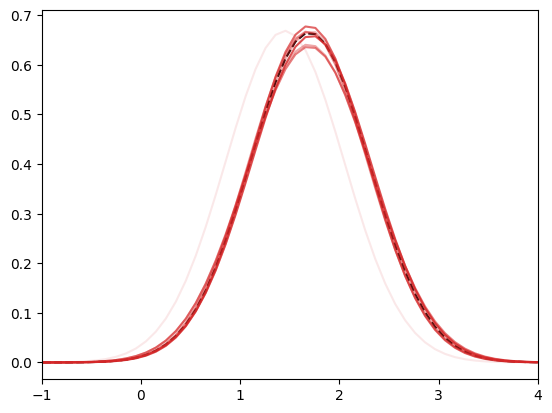

In [8]:
plt.plot(np.linspace(-10, 10, 200), np.exp(log_p(np.linspace(-10, 10, 200))), c='k', ls='--')
# ----- Train -----
# ----- Train -----
for t in range(1, 801):
    params, opt_state, key, loss = step(params, opt_state, key)
    if t % 100 == 0:
        sigma = jax.nn.softplus(params.rho)
        #print(f"iter {t:4d} | KL={loss:.6f} | mu={params.mu:.3f}  sigma={sigma:.3f}")
        plt.plot(np.linspace(-10, 10, 200), np.exp(log_q(np.linspace(-10, 10, 200), params.mu, sigma)), 
                 c='C3', alpha=np.min([0.001*float(t), 1.]))
plt.xlim(-1., 4)

In [9]:
# ----- Results -----
sigma = jax.nn.softplus(params.rho)
print("\nFinal variational params:")
print(f"mu={params.mu:.6f}  sigma={sigma:.6f}   (target: m0={m0:.6f}, s0={s0:.6f})")

# Optional: analytical KL(q||p) to verify convergence
def kl_gauss(mu, s, m, t):
    return jnp.log(t/s) + (s**2 + (mu - m)**2)/(2*t**2) - 0.5
print(f"KL(q||p)≈ {kl_gauss(params.mu, sigma, m0, s0):.8f}")



Final variational params:
mu=1.717662  sigma=0.605546   (target: m0=1.700000, s0=0.600000)
KL(q||p)≈ 0.00051850
